
# 台北市 CPI EDA（清整 + 統計 + 視覺化）

此 Notebook 會：

- 讀取 `pi00103yac.csv`（Big5/CP950 編碼，依 codebook）  
- 將民國年轉為西元年（+1911）  
- 從「項目」欄位擷取月份、建立 `date` 欄位（每月第一天）  
- 產出：清整後月資料、年度與年代彙整、以及三張圖（CPI 走勢、YoY 走勢、月份季節性）  
- **作圖規範**：使用 `matplotlib`、一張圖一個 figure、**不設定任何特定顏色**。

> 你可以直接執行所有儲存格，或修改輸入/輸出路徑以套用到自己的資料夾。


In [1]:
# 路徑參數（可自行修改）
from pathlib import Path

# 預設讀取你剛上傳的原始檔案
CSV_PATH = Path("pi00103yac.csv")  # 原始 CSV（CP950）
OUTDIR = Path("cpi_eda_outputs")   # 輸出資料夾

OUTDIR.mkdir(parents=True, exist_ok=True)
CSV_PATH, OUTDIR

(PosixPath('pi00103yac.csv'), PosixPath('cpi_eda_outputs'))

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 50)

In [3]:
def roc_to_gregorian(x):
    """將 '70年' 轉為 1981（+1911）。"""
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)", str(x))
    if not m:
        return np.nan
    return int(m.group(1)) + 1911


def parse_month(x):
    """從 '1月' 取出 1；非月份（如 '全年'）回傳 NaN。"""
    s = str(x)
    m = re.search(r"(\d+)\s*月", s)
    if m:
        month = int(m.group(1))
        if 1 <= month <= 12:
            return month
    return np.nan

In [4]:
# 讀檔（CP950/Big5）
df = pd.read_csv(CSV_PATH, encoding="cp950")
df.columns = df.columns.str.strip()

# 友善欄名（保留原名在 df 中，僅加掛英文別名）
rename_map = {
    "縣市別代碼": "city_code",
    "年別": "year_roc",
    "項目": "item",
    "原始值[統計數值]": "cpi_raw",
    "年增率[%]": "yoy_str",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# 年/月欄位
df["year"] = df.get("year_roc", pd.Series(dtype=object)).apply(roc_to_gregorian).astype("Int64")
df["month"] = df.get("item", pd.Series(dtype=object)).apply(parse_month).astype("Int64")

# 數值欄位
df["cpi_raw"] = pd.to_numeric(df.get("cpi_raw"), errors="coerce")
yoy_src = df.get("yoy_str")
if yoy_src is not None:
    df["yoy_pct"] = pd.to_numeric(yoy_src.astype(str).str.replace("%", "", regex=False), errors="coerce")
else:
    df["yoy_pct"] = np.nan

# 只保留月份資料並建立日期
df_monthly = df.dropna(subset=["month"]).copy()
df_monthly["date"] = pd.to_datetime(dict(
    year=df_monthly["year"].astype(int),
    month=df_monthly["month"].astype(int),
    day=1
))
df_monthly = df_monthly.sort_values("date").reset_index(drop=True)

df_monthly.head(10)

,city_code,year_roc,item,cpi_raw,yoy_str,year,month,yoy_pct,date
0,63000,70年,1月,45.34,--,1981,1,NaN,1981-01-01
1,63000,70年,2月,46.72,--,1981,2,NaN,1981-02-01
2,63000,70年,3月,47.42,--,1981,3,NaN,1981-03-01
3,63000,70年,4月,47.85,--,1981,4,NaN,1981-04-01
4,63000,70年,5月,47.71,--,1981,5,NaN,1981-05-01
5,63000,70年,6月,49.31,--,1981,6,NaN,1981-06-01
6,63000,70年,7月,49.21,--,1981,7,NaN,1981-07-01
7,63000,70年,8月,49.95,--,1981,8,NaN,1981-08-01
8,63000,70年,9月,50.72,--,1981,9,NaN,1981-09-01
9,63000,70年,10月,50.22,--,1981,10,NaN,1981-10-01


In [5]:
overview = {
    "rows_total": len(df),
    "rows_monthly": len(df_monthly),
    "columns": list(df.columns),
    "date_min": df_monthly["date"].min(),
    "date_max": df_monthly["date"].max(),
    "missing_cpi_raw": int(df_monthly["cpi_raw"].isna().sum()),
    "missing_yoy_pct": int(df_monthly["yoy_pct"].isna().sum()),
}
pd.DataFrame([overview])

,rows_total,rows_monthly,columns,date_min,date_max,missing_cpi_raw,missing_yoy_pct
0,580,536,"[city_code, year_roc, item, cpi_raw, yoy_str, ...",1981-01-01,2025-08-01,0,12


In [6]:
desc_cpi = df_monthly["cpi_raw"].describe().to_frame(name="cpi_raw_summary")
desc_yoy = df_monthly["yoy_pct"].describe().to_frame(name="yoy_pct_summary")

annual = (
    df_monthly.groupby("year", dropna=True)
    .agg(
        months=("month", "count"),
        cpi_avg=("cpi_raw", "mean"),
        cpi_min=("cpi_raw", "min"),
        cpi_max=("cpi_raw", "max"),
        yoy_avg=("yoy_pct", "mean"),
    )
    .reset_index()
    .sort_values("year")
)

def decade_label(y):
    return int(y // 10 * 10)

annual["decade"] = annual["year"].apply(decade_label)
decade = (
    annual.groupby("decade")
    .agg(
        years=("year", "nunique"),
        cpi_avg=("cpi_avg", "mean"),
        yoy_avg=("yoy_avg", "mean"),
    )
    .reset_index()
    .sort_values("decade")
)

display(desc_cpi)
display(desc_yoy)
display(annual.head(10))
display(decade)

,cpi_raw_summary
count,536.000000
mean,79.951530
std,17.902373
min,45.340000
25%,65.357500
50%,82.035000
75%,94.602500
max,111.260000


,yoy_pct_summary
count,524.000000
mean,1.913683
std,2.112498
min,-2.720000
25%,0.427500
50%,1.530000
75%,3.045000
max,9.320000


,year,months,cpi_avg,cpi_min,cpi_max,yoy_avg,decade
0,1981,12,48.605833,45.34,50.72,NaN,1980
1,1982,12,50.438333,49.17,52.00,3.820833,1980
2,1983,12,51.986667,50.63,52.83,3.105833,1980
3,1984,12,51.738333,50.65,52.22,-0.466667,1980
4,1985,12,51.921667,51.32,52.72,0.359167,1980
5,1986,12,52.409167,52.03,53.43,0.943333,1980
6,1987,12,52.202500,51.46,53.19,-0.395000,1980
7,1988,12,52.626667,51.69,53.68,0.814167,1980
8,1989,12,55.808333,54.02,58.14,6.034167,1980
9,1990,12,59.222500,57.32,62.07,6.113333,1990


,decade,years,cpi_avg,yoy_avg
0,1980,9,51.970833,1.776979
1,1990,10,71.808167,3.702167
2,2000,10,84.761667,1.138167
3,2010,10,94.748083,0.976917
4,2020,6,104.504236,1.971875


In [8]:
clean_csv_path = OUTDIR / "taipei_cpi_clean.csv"
summary_xlsx_path = OUTDIR / "taipei_cpi_summary.xlsx"

df_monthly.to_csv(clean_csv_path, index=False, encoding="utf-8")

with pd.ExcelWriter(summary_xlsx_path) as writer:
    pd.DataFrame([overview]).to_excel(writer, index=False, sheet_name="overview")
    desc_cpi.to_excel(writer, sheet_name="cpi_raw_summary")
    desc_yoy.to_excel(writer, sheet_name="yoy_pct_summary")
    annual.to_excel(writer, index=False, sheet_name="annual")
    decade.to_excel(writer, index=False, sheet_name="decade")

clean_csv_path, summary_xlsx_path

(PosixPath('cpi_eda_outputs/taipei_cpi_clean.csv'),
 PosixPath('cpi_eda_outputs/taipei_cpi_summary.xlsx'))

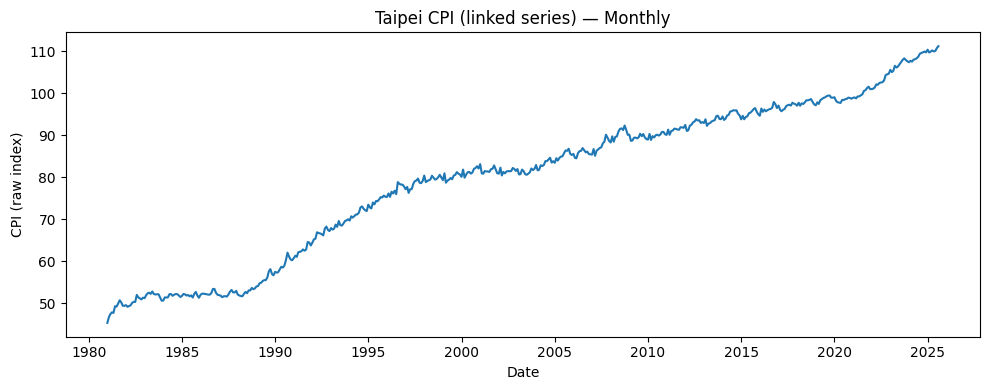

In [9]:
# 9.1 CPI over time
plt.figure(figsize=(10, 4))
plt.plot(df_monthly["date"], df_monthly["cpi_raw"])
plt.title("Taipei CPI (linked series) — Monthly")
plt.xlabel("Date")
plt.ylabel("CPI (raw index)")
plt.tight_layout()
(OUTDIR / "plot_cpi_over_time.png").unlink(missing_ok=True)
plt.savefig(OUTDIR / "plot_cpi_over_time.png", dpi=200)
plt.show()

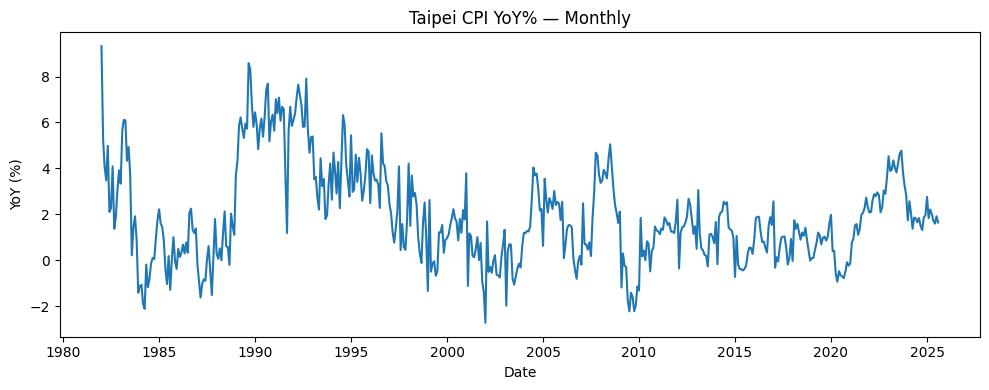

In [10]:
# 9.2 YoY% over time
plt.figure(figsize=(10, 4))
plt.plot(df_monthly["date"], df_monthly["yoy_pct"])
plt.title("Taipei CPI YoY% — Monthly")
plt.xlabel("Date")
plt.ylabel("YoY (%)")
plt.tight_layout()
(OUTDIR / "plot_yoy_over_time.png").unlink(missing_ok=True)
plt.savefig(OUTDIR / "plot_yoy_over_time.png", dpi=200)
plt.show()

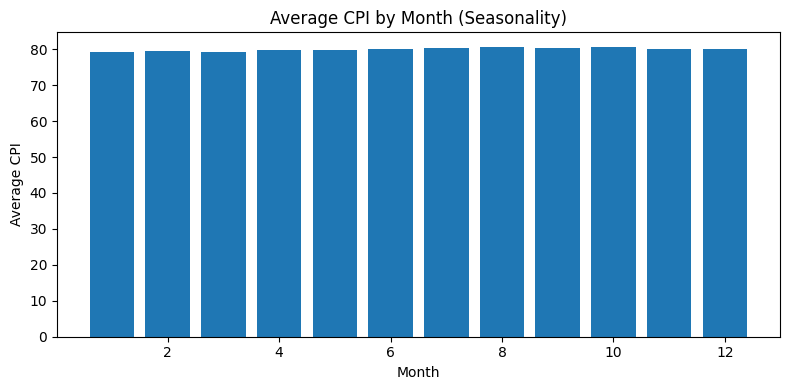

In [11]:
# 9.3 Seasonality (avg by month across years)
seasonality = (
    df_monthly.dropna(subset=["month"])
    .groupby("month")["cpi_raw"]
    .mean()
    .reindex(range(1, 13))
)

plt.figure(figsize=(8, 4))
plt.bar(seasonality.index.astype(int), seasonality.values)
plt.title("Average CPI by Month (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Average CPI")
plt.tight_layout()
(OUTDIR / "plot_cpi_seasonality.png").unlink(missing_ok=True)
plt.savefig(OUTDIR / "plot_cpi_seasonality.png", dpi=200)
plt.show()

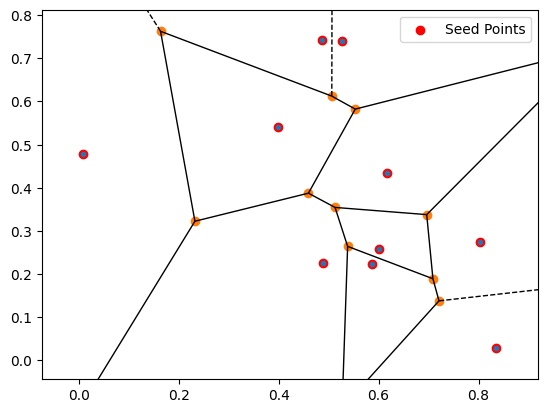

In [12]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

# 1️⃣ 建立隨機點
points = np.random.rand(10, 2)

# 2️⃣ 建立 Voronoi 圖
vor = Voronoi(points)

# 3️⃣ 繪製
fig = voronoi_plot_2d(vor)
plt.scatter(points[:,0], points[:,1], color='red', label='Seed Points')
plt.legend()
plt.show()
